In [1]:
#importing moduls numpy, matplotlib and sklearn
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_precision_recall_curve, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from joblib import dump, load

In [2]:
df = np.genfromtxt('mo_1particle_5extractions_slice1_pulito')    #upload the dataset


In [3]:
num_part = df[:,0]  #number of particles for each simulation
mass_bh = df[:,1]  #black hole's mass

num_col = df.shape[1]
x_coord = df[:,[4 + i for i in range(0,num_col-4,15)]]    #x,y-coordinates
y_coord = df[:,[5 + i for i in range(0,num_col-5,15)]]

r = np.sqrt(x_coord**2 + y_coord**2)  #radius on the plane of the sky
r_ord = np.sort(r)   
ind_r_ord = np.argsort(r)

vz = np.abs(df[:,[9 + i for i in range(0,num_col-9,15)]]) #z-component of the velocity
vz_ord = np.take_along_axis(vz, ind_r_ord, axis=1)

az = np.abs(df[:,[12 + i for i in range(0,num_col-12,15)]]) #z-component of the acceleration
az_ord = np.take_along_axis(az, ind_r_ord, axis=1)

a1z = np.abs(df[:,[15 + i for i in range(0,num_col-15,15)]]) #z-component of the jerk
a1z_ord = np.take_along_axis(a1z, ind_r_ord, axis=1)

a2z = np.abs(df[:,[18 + i for i in range(0,num_col-18,15)]]) #z-component of the snap
a2z_ord = np.take_along_axis(a2z, ind_r_ord, axis=1)

In [4]:
#Features matrix: projected radius, z-velocity, z-acceleration, z-jerk, z-snap
X = np.hstack((r_ord,vz_ord,az_ord,a1z_ord,a2z_ord))

#naming features
feature_type = ['r','vz','az', 'jz', 'sz']
feature_names = []
print('feature_types',len(feature_type))
n_part = r_ord.shape[1]
print('numero particelle',n_part)
for i in range(0,len(feature_type)):
    for j in range(1,n_part+1):
        feature_names.append(feature_type[i]+str(j))


feature_types 5
numero particelle 1


In [5]:
#definition of the y-vector (target) for a classifier model
#two classes: 0-class if there isn't an IMBH, 1-class if there is an IMBH 

mass_med = 0.5  #massa media degli elementi dell'ammasso?
mass_tot = num_part*mass_med  #total mass of each cluster (simulation)

y = np.zeros(len(mass_bh))  #initializing y-vector composed by zeros of length equal to mass_bh

mass_fraz = mass_bh*10**3/mass_tot  #ratio between mass of BH and mass of the cluster

for i in range(len(y)):  #loop to create the y-vector with the classes
    if mass_fraz[i] > 0.144: #there is an IMBH if mass_fraz>14%
        y[i] = 1

In [6]:
np.random.seed(0) #fissando il random seed i dati non sono influenzati dalla casualità 

In [7]:
#splitting the dataset in data test and data train+validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

#splitting the dataset train+validation in data train and data validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3)

In [8]:
#model with default parameters 
model = DecisionTreeClassifier()

In [9]:
##Post pruning decision trees with cost complexity pruning
#cost_complexity_pruning_path: compute the pruning path during Minimal Cost-Complexity Pruning
#return: ccp_alphas, impurities

path = model.cost_complexity_pruning_path(X_train, y_train) #recursively finds the node with the “weakest link” and alpha parameters
ccp_alphas, impurities = path.ccp_alphas, path.impurities   #returning the effective alphas and the corresponding total leaf impurities at each step of the pruning process
len_ccp_a = len(ccp_alphas)
print('Lunghezza del vettore dei parametri alpha:', len_ccp_a)

Lunghezza del vettore dei parametri alpha: 1581


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

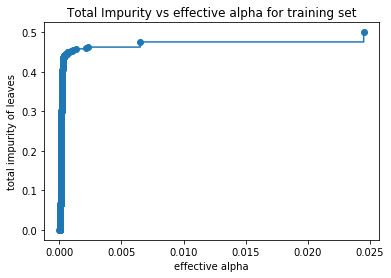

In [10]:
##PLOT: impurity vs alpha
fig, axe = plt.subplots()
axe.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
axe.set_xlabel("effective alpha")
axe.set_ylabel("total impurity of leaves")
axe.set_title("Total Impurity vs effective alpha for training set")
#fig.savefig('imp_alpha_1part.eps')

In [11]:
#Training of a decision tree using some effective alphas

#initialize an empty list
models = []

print('Inizio del ciclo sugli alpha per il fit')
passo = 10
indici = range(0,len_ccp_a, passo)  #loop on alpha parameters
for alpha in ccp_alphas[indici]:
    model = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha) #setting alpha
    model.fit(X_train, y_train) #fit using effective alphas
    models.append(model)  #saving all models corresponding to effective alphas
print("Number of nodes in the last tree is: {}".format(
      models[-1].tree_.node_count))
print("Last model:", models[-1])

Inizio del ciclo sugli alpha per il fit
Number of nodes in the last tree is: 1
Last model: DecisionTreeClassifier(ccp_alpha=0.02449750025507602, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')


In [12]:
##Predictions and accuracy score
#maximum of accuracy score on the data validation and corresponding accuracy on the data train

#initialize empty lists
p_trains = []
p_vals = []
acc_trains = []
acc_vals = []

print('Inizio del ciclo sugli alpha selezionati per la predizione e calcolo delle accuratezze sui data train e validation')

for i in range(0,len(indici)):  #loop on alpha parameters
    p_train = models[i].predict(X_train)  #prediction on data train
    p_val = models[i].predict(X_val)  #prediction on data validation
    acc_train = accuracy_score(y_train, p_train)  #accuracy between the predicted value and the real value on data train
    acc_val = accuracy_score(y_val, p_val)  #accuracy between the predicted value and the real value on data validation 
    p_trains.append(p_train)  #filling the empty lists by saving all predictions and accuracy, on the data train and validation
    p_vals.append(p_val)
    acc_trains.append(acc_train)
    acc_vals.append(acc_val)
    
k = np.argmax(acc_vals)   #indice al quale  acc_val è massimo

#comparing with data test: prediction and accuracy
print('Sto calcolando la predizione e accuratezza sui dati di test')
p_test = models[k].predict(X_test)  #prediction on test data using the model at which acc_vals is maximum
acc_test = accuracy_score(y_test, p_test)  #accuracy between the predicted value and the real value on data test

#print results
print('RISULTATI:')
print('acc_val_max:', max(acc_vals))
print('indice del modello per cui acc_val è massimo:', k)
print('acc_train_'+str(k)+':', acc_trains[k])
print('acc_test_'+str(k)+':', acc_test)

Inizio del ciclo sugli alpha selezionati per la predizione e calcolo delle accuratezze sui data train e validation
Sto calcolando la predizione e accuratezza sui dati di test
RISULTATI:
acc_val_max: 0.6251707650273224
indice del modello per cui acc_val è massimo: 156
acc_train_156: 0.6368760064412239
acc_test_156: 0.6137295081967213


In [13]:
#print of the model at which acc_vals is maximum 
print('modello del minimo acc_val:', models[k])
print('Numero progressivo del modello relativo ad alpha scelto',indici[k])

modello del minimo acc_val: DecisionTreeClassifier(ccp_alpha=0.00047429668328723314, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')
Numero progressivo del modello relativo ad alpha scelto 1560


In [14]:
#scatter plot function
#input: x, y, xlabel, ylabel, title
#output: scatter plot

def scatterplot(x, y, xlab, ylab, tit):# name):
    fig = plt.figure()
    plt.scatter(x, y, marker='.', c='blue')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(tit)
    plt.show()
    #fig.savefig(name)
    #return fig

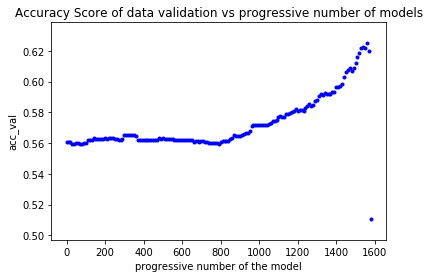

In [15]:
#scatter-plot: acc_val vs progressive number of the model
scatterplot(indici, acc_vals, 'progressive number of the model', 'acc_val', 'Accuracy Score of data validation vs progressive number of models')#'acc_val_1part.eps' )

In [16]:
##Zoom in the maximum of acc_vals zone repeating the same procedure 
#training of a decision tree using some effective alphas

#initialize an empty list
models2 = []

print('Inizio del ciclo sugli alpha per il fit nella zona del massimo')

mod_accvalmax = indici[k] #corresponding model to the alpha value for which acc_val is maximum
indici2=range(mod_accvalmax-passo,mod_accvalmax+passo)  #loop on alpha parameters in the zone of maximum
for alpha in ccp_alphas[indici2]:
    model2 = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    model2.fit(X_train, y_train)  #fit using effective alphas
    models2.append(model2)  #saving all models corresponding to effective alphas
print("Number of nodes in the last tree is: {}".format(
      models2[-1].tree_.node_count))
print("Last model:", models2[-1])

Inizio del ciclo sugli alpha per il fit nella zona del massimo
Number of nodes in the last tree is: 31
Last model: DecisionTreeClassifier(ccp_alpha=0.0006791822629454852, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')


In [17]:
##Zoom in the zone of maximum
##predictions and accuracy scores
#maximum of accuracy score on data validation and corresponding error on the data train

#initialize empty lists
p_trains2 = []
p_vals2 = []
acc_trains2 = []
acc_vals2 = []


print('Inizio del ciclo sugli alpha selezionati per la predizione e calcolo delle accuratezze sui data train e validation')
for i in range(0,len(indici2)):  #loop on alpha parameters in the maximum zone
    p_train2 = models2[i].predict(X_train)  #prediction on data train
    p_val2 = models2[i].predict(X_val)  #prediction on data validation
    acc_train2 = accuracy_score(y_train, p_train2)  #accuracy score between the predicted value and the real value on data train
    acc_val2 = accuracy_score(y_val, p_val2)  #accuracy score between the predicted value and the real value on data validation
    p_trains2.append(p_train2)  #filling the empty lists by saving all predictions and accuracy score, on the data train and validation
    p_vals2.append(p_val2)
    acc_trains2.append(acc_train2)
    acc_vals2.append(acc_val2)
    
k2 = np.argmax(acc_vals2)  #indice al quale  acc_val è massimo

#comparing with data test: prediction and accuracy score
print('Sto calcolando la predizione e accuratezza sui dati di test')
p_test2 = models2[k2].predict(X_test)  #prediction on test data using the model at which acc_vals is maximum
acc_test2 = accuracy_score(y_test, p_test2)  #accuracy score between the predicted value and the real value on data test

#print results
print('RISULTATI-ZOOM:')
print('acc_val_max:', max(acc_vals2))
print('indice del modello per acc_val_max:', k2)
print('corrispondente accuratezza sui data train, acc_train_'+str(k2)+':', acc_trains2[k2])
print('risultato sui data test, acc_test:', acc_test2)


Inizio del ciclo sugli alpha selezionati per la predizione e calcolo delle accuratezze sui data train e validation
Sto calcolando la predizione e accuratezza sui dati di test
RISULTATI-ZOOM:
acc_val_max: 0.6289275956284153
indice del modello per acc_val_max: 13
corrispondente accuratezza sui data train, acc_train_13: 0.6365100278143756
risultato sui data test, acc_test: 0.6180327868852459


In [18]:
##Zoom in the zone of maximum
#Saving and printing the model at which acc_vals is maximum 
clf_tree = models2[k2]
dump(clf_tree, 'clf_tree.joblib')
print('modello del massimo acc_val:', clf_tree)

modello del massimo acc_val: DecisionTreeClassifier(ccp_alpha=0.0005228450619616659, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')


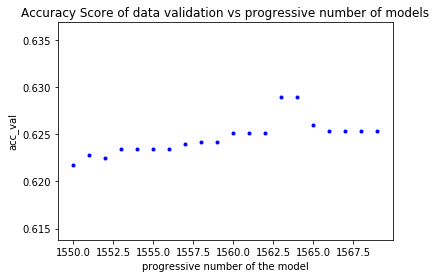

In [19]:
##Zoom in the zone of maximum
#scatter-plot: acc_val vs progressive number of the model
scatterplot(indici2, acc_vals2, 'progressive number of the model', 'acc_val', 'Accuracy Score of data validation vs progressive number of models')#'acc_val_1part_zoom.eps')

In [20]:
#Classification report
report = classification_report(y_test, p_test2)
print(report)

              precision    recall  f1-score   support

         0.0       0.60      0.67      0.63      2415
         1.0       0.64      0.57      0.60      2465

    accuracy                           0.62      4880
   macro avg       0.62      0.62      0.62      4880
weighted avg       0.62      0.62      0.62      4880



Text(0.5, 0, 'Predicated Label')

<Figure size 1440x1440 with 0 Axes>

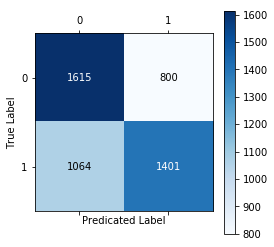

In [21]:
##Confusion matrix plot

#cm= skplt.metrics.plot_confusion_matrix(y_test, p_test2)
cm = confusion_matrix(y_test, p_test2)

plt.figure(figsize=(20, 20))
plt.matshow(cm, cmap=plt.cm.Blues)
thresh = (cm.max()+cm.min()) / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                ha="center", va="center",
                color="white" if  cm[i, j] == 0 or cm[i, j] > thresh else "black") 
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicated Label')
#plt.savefig('cm_1part.eps')



In [22]:
#get importance
importance = clf_tree.feature_importances_

#summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v)) 

Feature: 0, Score: 0.17228
Feature: 1, Score: 0.05450
Feature: 2, Score: 0.70986
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.06336


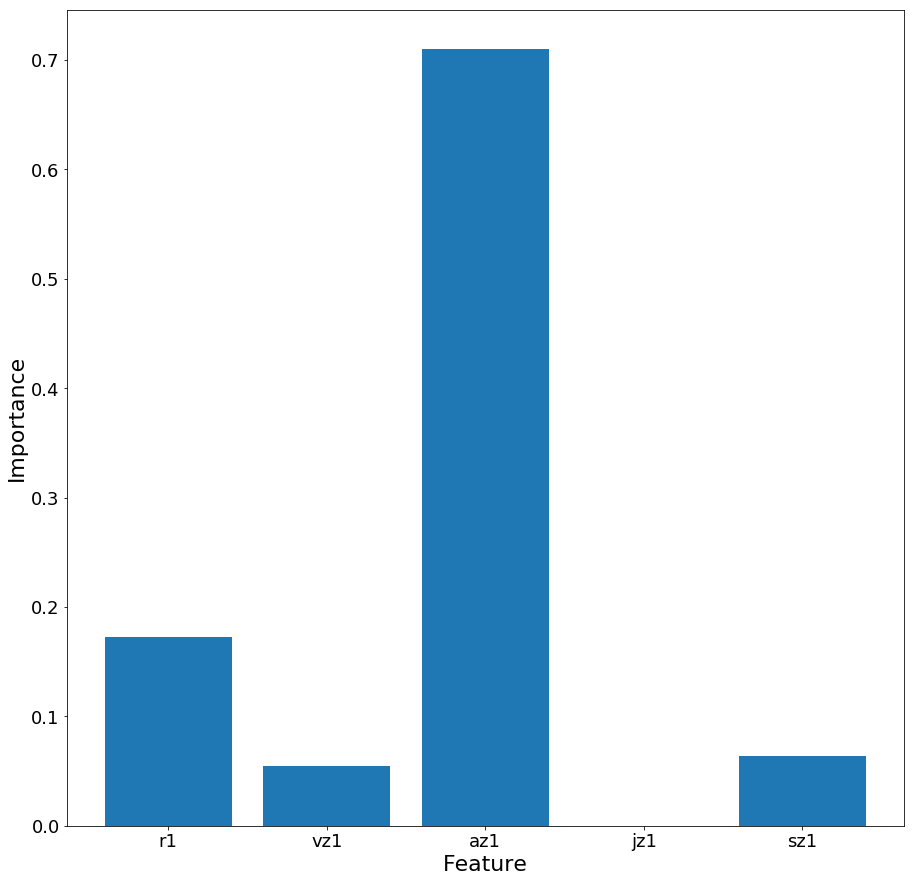

In [25]:
#features importance's plot
bar_imp = plt.figure(figsize=(15,15))
#plt.bar([x for x in range(len(importance))], importance)
plt.bar([x for x in feature_names], importance)
plt.xlabel('Feature',fontsize=22)
plt.ylabel('Importance',fontsize=22)
plt.xticks(fontsize= 18, rotation=0)
plt.yticks(fontsize= 18)
plt.show()

#bar_imp.savefig('bar_imp_1part.eps')